In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading only ORF similarities since YAP1 does not have a phenotype in CRISPR

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')

In [3]:
# All YAP1 connections in KG with score < 0.4

knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph = pd.concat(
    [
        knowledge_graph,
        knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_unknown = (
    knowledge_graph.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .query("gene_kg < 0.4")
    .query("gene_1=='YAP1'")[["gene_1", "gene_2", "gene_kg"]]
)

In [4]:
# YAP1 strongest n connections

n = 15

yap1_df = (
    orf_similarity_percentile_df["YAP1"]
    .reset_index()
    .rename(columns={"gene_1": "Metadata_Gene_Symbol", "YAP1": "percentile"})
    .query("Metadata_Gene_Symbol!='YAP1'")
    .query("Metadata_Gene_Symbol in @knowledge_graph_unknown.gene_2")
)

yap1_gene_list = (
    list(yap1_df.nlargest(n, "percentile").Metadata_Gene_Symbol)
    + list(yap1_df.nsmallest(n, "percentile").Metadata_Gene_Symbol)
    + ["YAP1"]
)

In [5]:
# Create ORF table and knowledge graph table for plotting

orf_values = orf_similarity_percentile_df.loc[yap1_gene_list, yap1_gene_list].values
np.fill_diagonal(orf_values, 1)
orf_df = pd.DataFrame(orf_values, index=yap1_gene_list, columns=yap1_gene_list)

knowledge_graph = knowledge_graph.query("gene_1 in @yap1_gene_list").query(
    "gene_2 in @yap1_gene_list"
)

knowledge_graph = pd.pivot(
    knowledge_graph.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    ),
    index="gene_1",
    columns="gene_2",
    values="gene_kg",
).fillna(1)

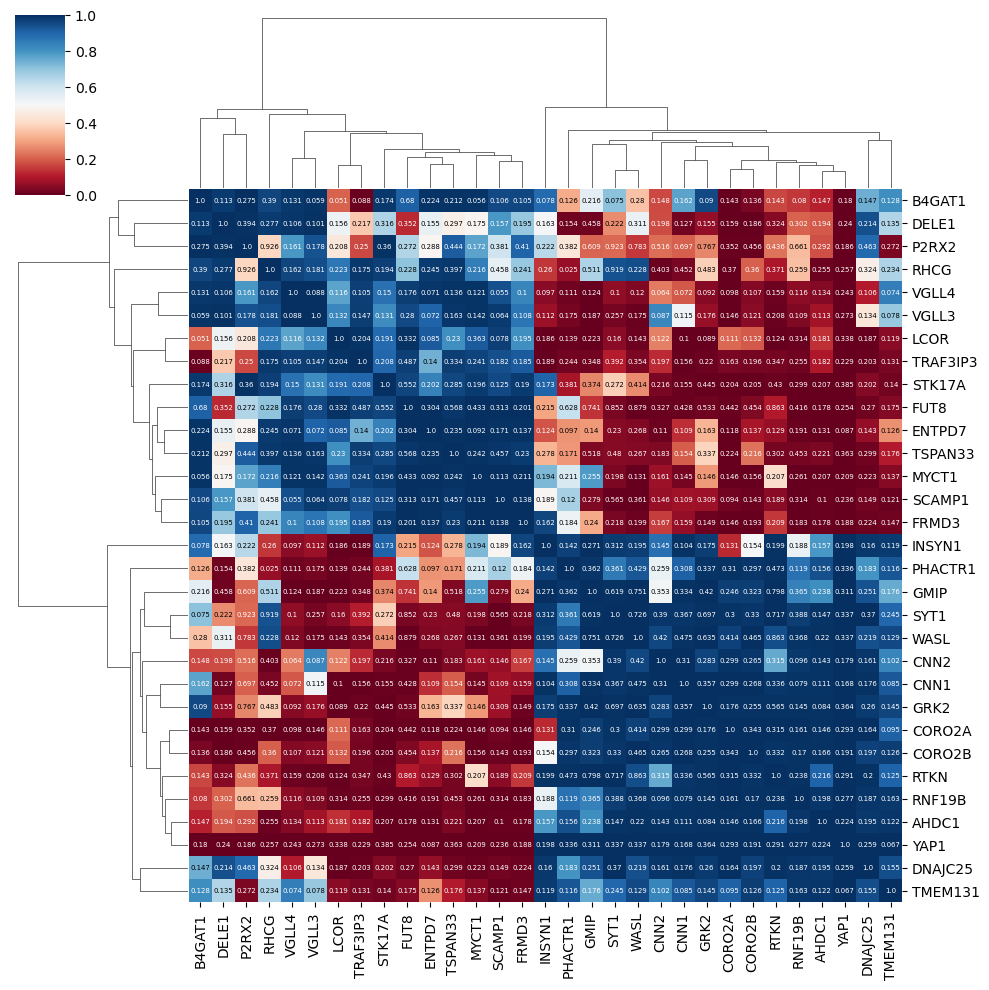

In [6]:
g = sns.clustermap(
    orf_df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
        for j in range(len(clustermap_df.columns)):
            gene_1 = clustermap_df.index[i]
            gene_2 = clustermap_df.columns[j]
            orf_kg_gene_pair = knowledge_graph.loc[gene_1, gene_2]
            text = f"{orf_kg_gene_pair}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontsize=5)

plt.savefig("figures/YAP1-connections.png", dpi=300)
plt.savefig("figures/YAP1-connections.svg", dpi=300)

In [7]:
print(orf_df["YAP1"].to_markdown())

|          |        YAP1 |
|:---------|------------:|
| CORO2A   | 0.999629    |
| CNN1     | 0.999188    |
| CORO2B   | 0.999103    |
| RTKN     | 0.998629    |
| SYT1     | 0.998396    |
| AHDC1    | 0.998233    |
| CNN2     | 0.997744    |
| GRK2     | 0.997673    |
| INSYN1   | 0.997455    |
| RNF19B   | 0.997446    |
| GMIP     | 0.997403    |
| DNAJC25  | 0.99738     |
| WASL     | 0.997307    |
| PHACTR1  | 0.996814    |
| TMEM131  | 0.996407    |
| STK17A   | 0.000236769 |
| LCOR     | 0.00044135  |
| MYCT1    | 0.000610485 |
| DELE1    | 0.000741828 |
| SCAMP1   | 0.000959437 |
| VGLL4    | 0.00106128  |
| FUT8     | 0.00108269  |
| VGLL3    | 0.00110628  |
| P2RX2    | 0.00114464  |
| B4GAT1   | 0.00125943  |
| TRAF3IP3 | 0.00139069  |
| ENTPD7   | 0.00148683  |
| TSPAN33  | 0.00173701  |
| FRMD3    | 0.00196037  |
| RHCG     | 0.00207006  |
| YAP1     | 1           |


In [8]:
knowledge_graph_values = knowledge_graph.values
np.fill_diagonal(knowledge_graph_values, 0)

count = 0
for i in range(len(knowledge_graph_values)):
    for j in range(len(knowledge_graph_values[i])):
        if knowledge_graph_values[i, j] > 0.7:
            count += 1

print(count)
print(knowledge_graph_values.shape)

28
(31, 31)
